In [1]:
# Import all the necessary classes.
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.special import expit
import seaborn as sns
from sklearn.datasets import make_blobs

In [2]:
# Reset PN sequence generator.
seed = 42
np.random.seed(seed)

### Definição da classe `LogisticRegressor`

In [3]:
class LogisticRegressor:
    '''Class implementing the Logistic Regressor.'''

    def error_function(self, x, y, a):
        '''Calculate the average error.'''
        h = expit(x.dot(a))
        error = -(1/len(y))*np.sum(y.T.dot(np.log(h)) + (1-y).T.dot(np.log((1-h) )))
        return error

    def predict(self, x, a):
        '''Predict class labels for samples in X.'''
        h = expit(x.dot(a))
        c = np.zeros((len(h), 1))
        for i in range(0, len(h)):
            if(h[i] >= 0.5):
                c[i,0] = 1.0
        return c
    
    def predict_proba(self, x, a):
        '''Probability estimates.'''
        h = expit(x.dot(a))
        return h
    
    def fit(self, x_train, y_train, x_test, y_test, alpha, n_iterations, seed):
        '''Fit the model according to the given training data.'''
        # Reset PN sequence generator.
        np.random.seed(seed)
        
        # Random initialization of parameters.
        a = np.random.randn(x_train.shape[1], 1)

        # Create array for storing error values.
        Jgd = np.zeros(n_iterations+1)
        Jgd_v = np.zeros(n_iterations+1)

        # Calculate initial error.
        Jgd[0] = self.error_function(x_train, y_train, a)
        Jgd_v[0] = self.error_function(x_test, y_test, a)

        # Batch gradient-descent loop.
        minimum_val_error = float("inf")
        error = float("inf")
        iteration = 0
        while iteration < n_iterations:
            gradients = -1/len(y_train)*x_train.T.dot(y_train - expit(x_train.dot(a)) )
            a = a - alpha * gradients
            Jgd[iteration+1] = self.error_function(x_train, y_train, a)
            Jgd_v[iteration+1] = self.error_function(x_test, y_test, a)
            error = np.abs(Jgd[iteration+1] - Jgd[iteration])
            # Early-stop: Store weights for the smallest validation error ever.
            if(Jgd_v[iteration+1] < minimum_val_error):
                minimum_val_error = Jgd_v[iteration+1]
                a_min = a        
            iteration += 1
        return a_min, minimum_val_error, iteration, Jgd, Jgd_v

### Gera exemplos de quatro classes.

In [4]:
# Number of examples.
N = 1000

# Create 4-class dataset for classification.
centers = [[-5, 0], [0, 1.5], [5, -1], [10, 1.5]]
X, y = make_blobs(n_samples=N, centers=centers, random_state=seed)

### Plota as 4 classes.

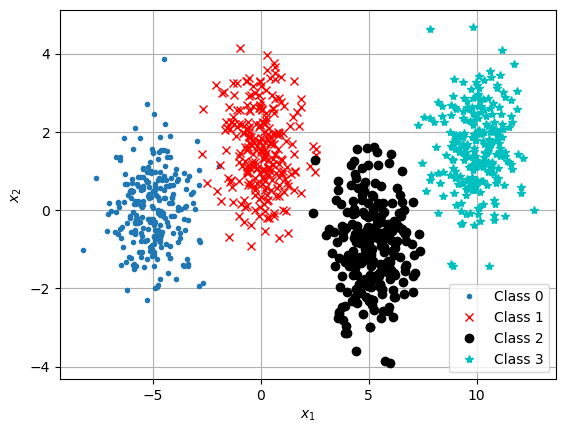

In [5]:
# Indexes of elements belonging to each class.
idx0 = np.argwhere(y == 0)
idx1 = np.argwhere(y == 1)
idx2 = np.argwhere(y == 2)
idx3 = np.argwhere(y == 3)

plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.grid()
plt.show()

**Observação**:

+ Por serem o formato mais simples, usaremos retas como funções discriminantes.

# Um-Contra-o-Resto

$Q = 4$, portanto, devemos treinar $4$ classificadores binários (e.g., regressor logístico).

**OBS**.: Transformamos um problema de $Q=4$ classes em $Q=4$ problemas binários.

### Classe 0 versus o resto

Classe 0 é a classe positiva e as restantes formam a classe negativa.

In [6]:
# Change the labels to only two possible ones.
y_mod1 = np.zeros((N,1))
y_mod1[idx0] = 1.0
y_mod1[idx1] = 0.0
y_mod1[idx2] = 0.0
y_mod1[idx3] = 0.0

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y_mod1, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [7]:
# learning rate.
alpha = 0.3

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf1 = LogisticRegressor()

# Train the model.
a_min1, minimum_val_error, iteration, Jgd, Jgd_v = clf1.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf1.predict(X_test, a_min1)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 0.99


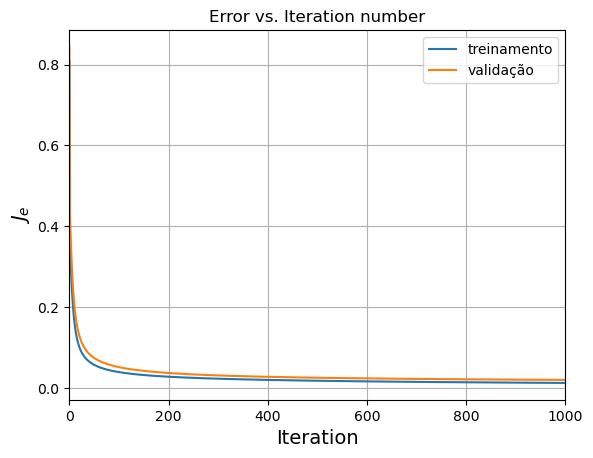

In [8]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

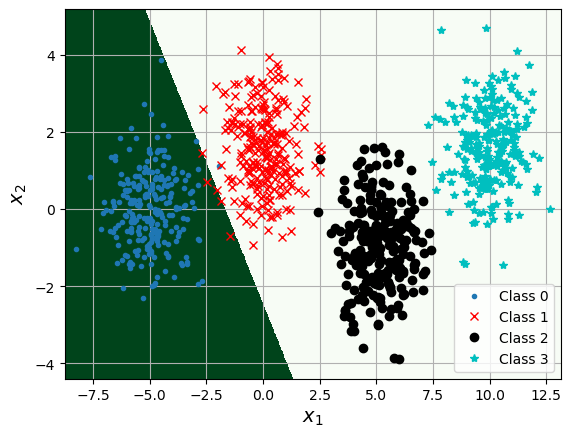

In [9]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf1.predict(attribute_matrix, a_min1)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 1 versus o resto

Classe 1 é a classe positiva e as restantes formam a classe negativa.

In [10]:
# Change the labels to only two possible ones.
y_mod2 = np.zeros((N,1))
y_mod2[idx0] = 0.0
y_mod2[idx1] = 1.0
y_mod2[idx2] = 0.0
y_mod2[idx3] = 0.0

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y_mod2, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [11]:
# learning rate.
alpha = 0.3

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf2 = LogisticRegressor()

# Train the model.
a_min2, minimum_val_error, iteration, Jgd, Jgd_v = clf2.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf2.predict(X_test, a_min2)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 0.7766666666666666


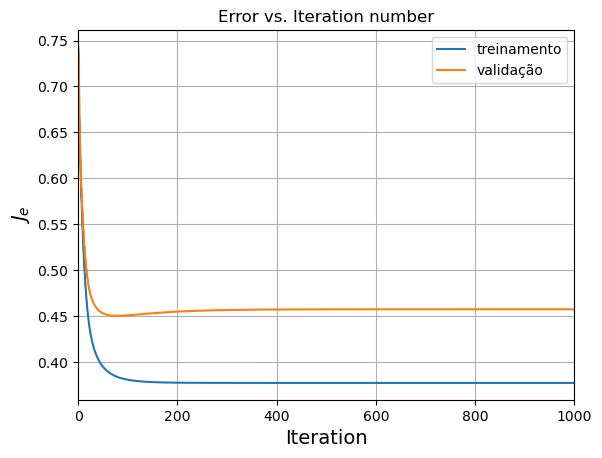

In [12]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

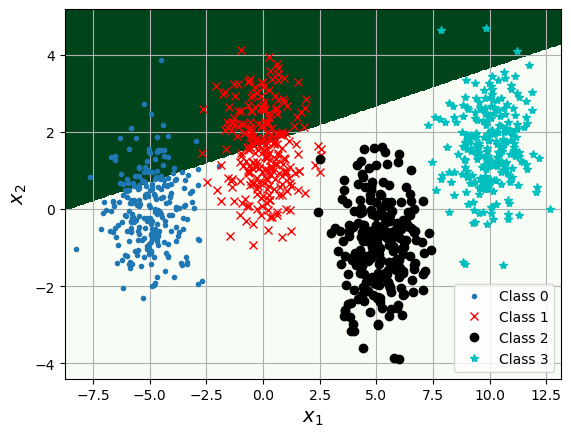

In [13]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf2.predict(attribute_matrix, a_min2)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 2 versus o resto

Classe 2 é a classe positiva e as restantes formam a classe negativa.

In [14]:
# Change the labels to only two possible ones.
y_mod3 = np.zeros((N,1))
y_mod3[idx0] = 0.0
y_mod3[idx1] = 0.0
y_mod3[idx2] = 1.0
y_mod3[idx3] = 0.0

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y_mod3, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [15]:
# learning rate.
alpha = 0.3

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf3 = LogisticRegressor()

# Train the model.
a_min3, minimum_val_error, iteration, Jgd, Jgd_v = clf3.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf3.predict(X_test, a_min3)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 0.9166666666666666


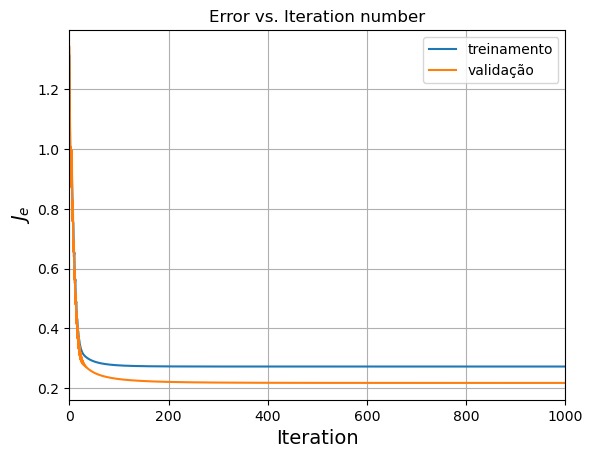

In [16]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

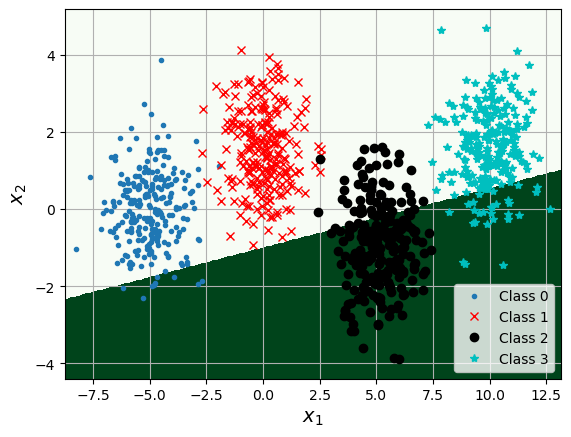

In [17]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf3.predict(attribute_matrix, a_min3)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 3 versus o resto

Classe 3 é a classe positiva e as restantes formam a classe negativa.

In [18]:
# Change the labels to only two possible ones.
y_mod4 = np.zeros((N,1))
y_mod4[idx0] = 0.0
y_mod4[idx1] = 0.0
y_mod4[idx2] = 0.0
y_mod4[idx3] = 1.0

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X, y_mod4, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [19]:
# learning rate.
alpha = 0.3

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf4 = LogisticRegressor()

# Train the model.
a_min4, minimum_val_error, iteration, Jgd, Jgd_v = clf4.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf4.predict(X_test, a_min4)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


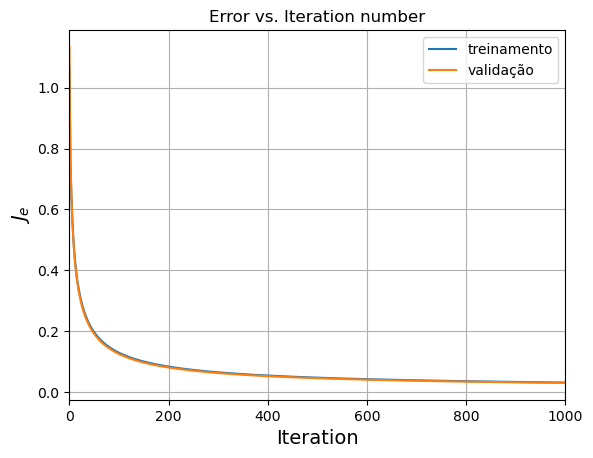

In [20]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration', fontsize=14)
plt.ylabel('$J_e$', fontsize=14)
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

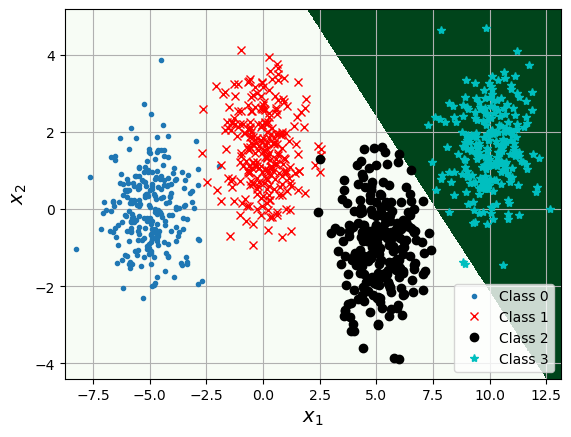

In [21]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf4.predict(attribute_matrix, a_min4)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Predição

Função que combina todos os classificadores binários e decide por aquele com o **maior valor de saída da função hipótese de classificação**.

In [22]:
X_ = np.c_[np.ones((len(y), 1)), X]

def predict(X_, clf1, clf2, clf3, clf4, a_min1, a_min2, a_min3, a_min4):
    N = X_.shape[0]
    y_pred = np.zeros((N, 1))
    for i in range(0, N):
        h1 = clf1.predict_proba(X_[i,:], a_min1)
        h2 = clf2.predict_proba(X_[i,:], a_min2)
        h3 = clf3.predict_proba(X_[i,:], a_min3)
        h4 = clf4.predict_proba(X_[i,:], a_min4)
        proba_list = [h1[0], h2[0], h3[0], h4[0]]
        y_pred[i] = np.argmax(proba_list) # retorna o índice do elemento com maior valor, que é, consequentemente, a classe.
    return y_pred

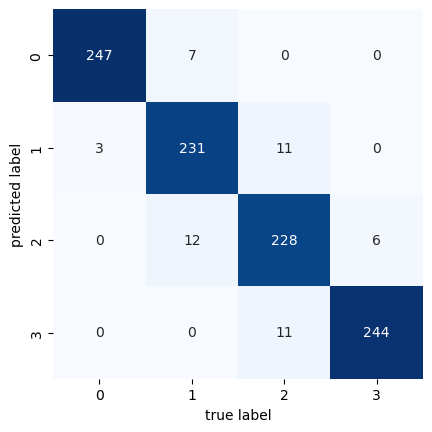

In [23]:
y_pred = predict(X_, clf1, clf2, clf3, clf4, a_min1, a_min2, a_min3, a_min4)

# Plot the confusion matrix
mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2','3'], yticklabels=['0','1','2','3'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [24]:
# Calculate accuracy of class predictions.
accuracy_score(y, y_pred)

0.95

### Regiões de decisão resultantes da combinação dos $Q$ classificadores binários.

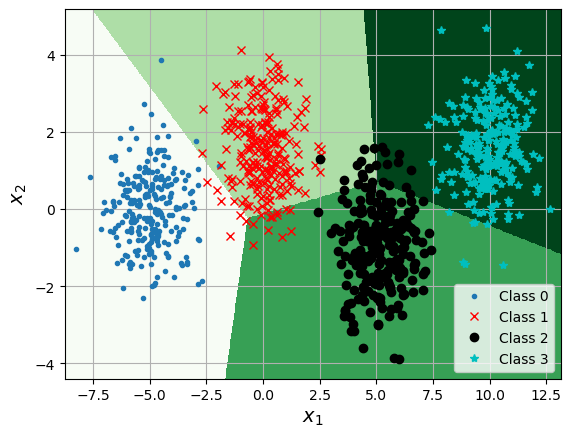

In [25]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = predict(attribute_matrix, clf1, clf2, clf3, clf4, a_min1, a_min2, a_min3, a_min4)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

# Um-Contra-Um

$Q = 4$, assim, devemos treinar $\frac{Q(Q-1)}{2} = 6$ classificadores binários.

**OBS**.: Transformamos um problema de $Q=4$ classes em $\frac{Q(Q-1)}{2} = 6$ problemas binários.

### Classe 0 versus 1

Classe 0 é a classe positiva e a classe 1 é a negativa.

In [26]:
idxC1 = idx0.ravel()
idxC2 = idx1.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1], y_mod[idxC2]]

X_mod = np.r_[X[idxC1], X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [27]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf1 = LogisticRegressor()

# Train the model.
a_min1, minimum_val_error, iteration, Jgd, Jgd_v = clf1.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf1.predict(X_test, a_min1)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 0.9933333333333333


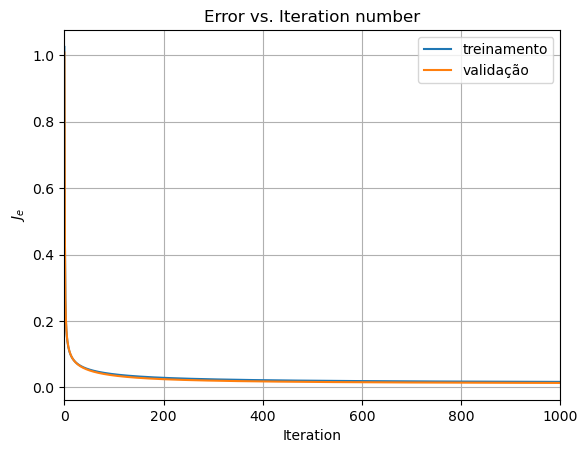

In [28]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

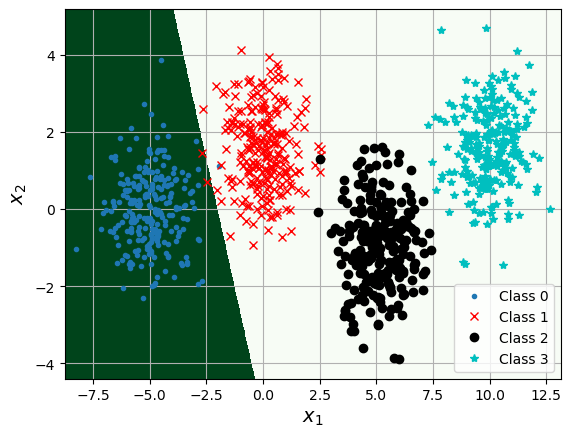

In [29]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf1.predict(attribute_matrix, a_min1)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 0 versus 2

Classe 0 é a classe positiva e a classe 2 é a negativa.

In [30]:
idxC1 = idx0.ravel()
idxC2 = idx2.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]

X_mod = np.r_[X[idxC1],  X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [31]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf2 = LogisticRegressor()

# Train the model.
a_min2, minimum_val_error, iteration, Jgd, Jgd_v = clf2.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf2.predict(X_test, a_min2)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


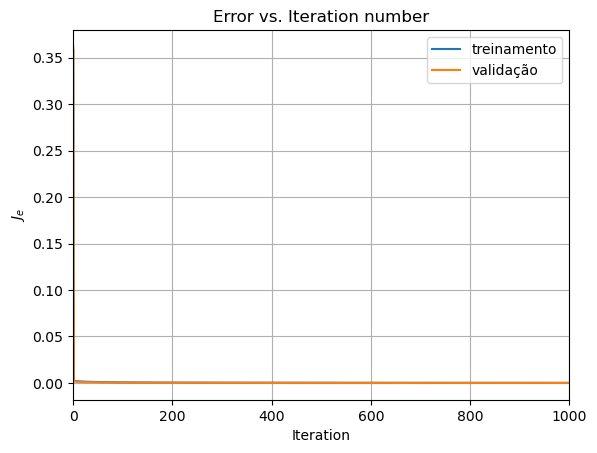

In [32]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.legend()
plt.show()

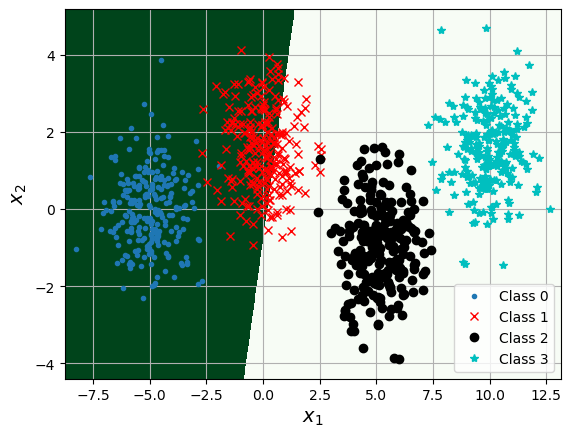

In [33]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf2.predict(attribute_matrix, a_min2)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 0 versus 3

Classe 0 é a classe positiva e a classe 3 é a negativa.

In [34]:
idxC1 = idx0.ravel()
idxC2 = idx3.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1],  y_mod[idxC2]]

X_mod = np.r_[X[idxC1],  X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [35]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf3 = LogisticRegressor()

# Train the model.
a_min3, minimum_val_error, iteration, Jgd, Jgd_v = clf3.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf3.predict(X_test, a_min3)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


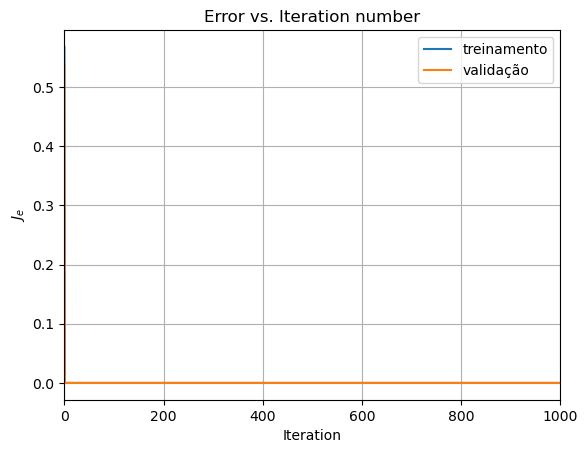

In [36]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

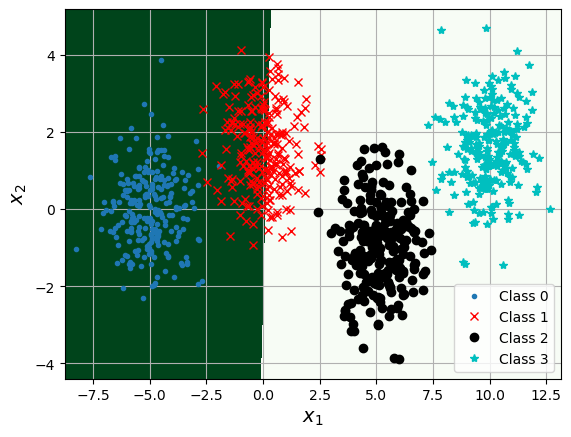

In [37]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf3.predict(attribute_matrix, a_min3)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 1 versus 2

Classe 1 é a classe positiva e a classe 2 é a negativa.

In [38]:
idxC1 = idx1.ravel()
idxC2 = idx2.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1], y_mod[idxC2]]

X_mod = np.r_[X[idxC1], X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [39]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf4 = LogisticRegressor()

# Train the model.
a_min4, minimum_val_error, iteration, Jgd, Jgd_v = clf4.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf4.predict(X_test, a_min4)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


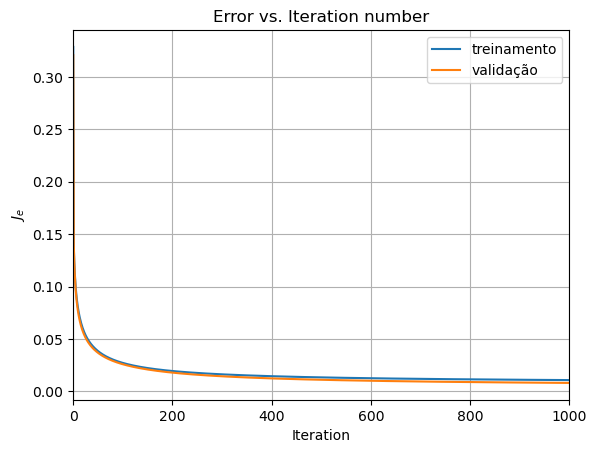

In [40]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

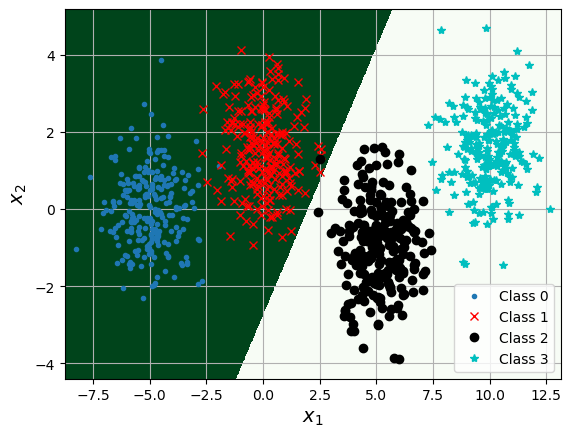

In [41]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf4.predict(attribute_matrix, a_min4)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 1 versus 3

Classe 1 é a classe positiva e a classe 3 é a negativa.

In [42]:
idxC1 = idx1.ravel()
idxC2 = idx3.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1], y_mod[idxC2]]
X_mod = np.r_[X[idxC1], X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [43]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf5 = LogisticRegressor()

# Train the model.
a_min5, minimum_val_error, iteration, Jgd, Jgd_v = clf5.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf5.predict(X_test, a_min5)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


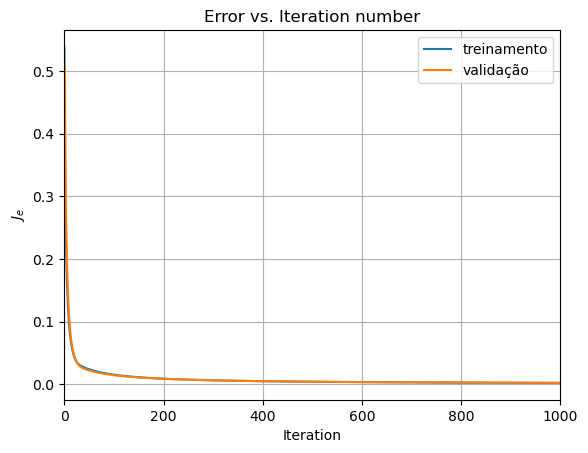

In [44]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

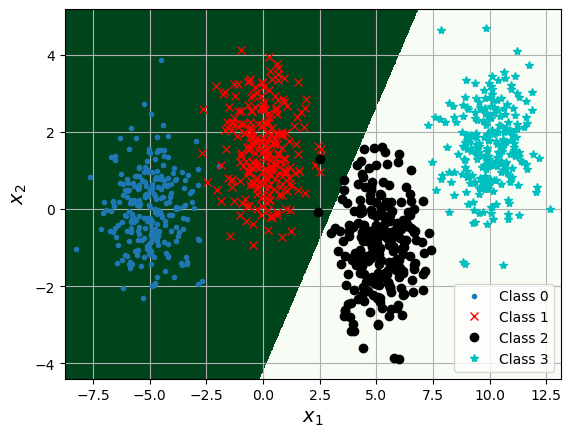

In [45]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf5.predict(attribute_matrix, a_min5)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Classe 2 versus 3

Classe 2 é a classe positiva e a classe 3 é a negativa.

In [46]:
idxC1 = idx2.ravel()
idxC2 = idx3.ravel()

y_mod = np.zeros((N,1))
y_mod[idxC1] = 1.0
y_mod[idxC2] = 0.0
y_mod = np.r_[y_mod[idxC1], y_mod[idxC2]]
X_mod = np.r_[X[idxC1], X[idxC2]]

# Split array into random train and test subsets.
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.3, random_state=seed)

# Create attribute matrix.
X_train = np.c_[np.ones((len(y_train), 1)), X_train]
X_test = np.c_[np.ones((len(y_test), 1)), X_test]

In [47]:
# learning rate.
alpha = 0.9

# Maximum number of iterations.
n_iterations = 1000

# Instantiate the logistic regression class.
clf6 = LogisticRegressor()

# Train the model.
a_min6, minimum_val_error, iteration, Jgd, Jgd_v = clf6.fit(X_train, y_train, X_test, y_test, alpha, n_iterations, seed)

# Calculate accuracy.
y_pred = clf6.predict(X_test, a_min6)
acc = accuracy_score(y_test, y_pred)
print('Acc:', acc)

Acc: 1.0


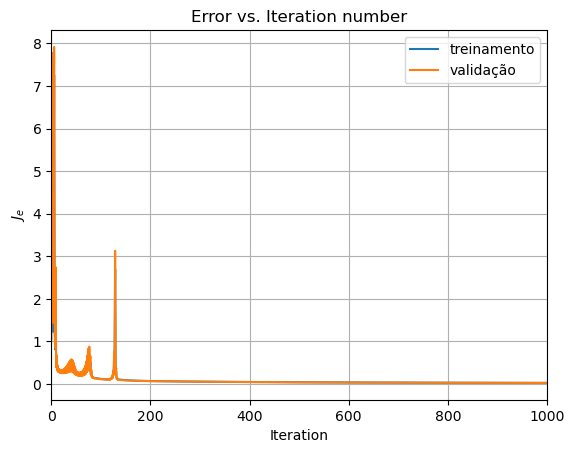

In [48]:
plt.plot(np.arange(0, iteration), Jgd[0:iteration], label='treinamento')
plt.plot(np.arange(0, iteration), Jgd_v[0:iteration], label='validação')
plt.xlim((0, iteration))
plt.xlabel('Iteration')
plt.ylabel('$J_e$')
plt.title('Error vs. Iteration number')
plt.legend()
plt.grid()
plt.show()

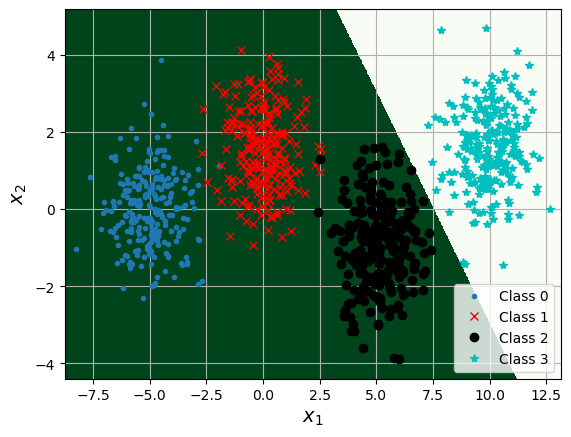

In [49]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = clf6.predict(attribute_matrix, a_min6)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()

### Predição

Função que combina todos os classificadores e decide pela classe com **maior número de votos**.

In [50]:
X_ = np.c_[np.ones((len(y), 1)), X]

def predict(X_, clf1, clf2, clf3, clf4, clf5, clf6, a_min1, a_min2, a_min3, a_min4, a_min5, a_min6):
    N = X_.shape[0]
    y_pred = np.zeros((N, 1))
    for i in range(0, N):
        classes = np.zeros((4,))

        # Classes 0 and 1.
        if(clf1.predict(X_[i,:], a_min1) == 1):
            classes[0] += 1
        else:
            classes[1] += 1

        # Classes 0 and 2.
        if(clf2.predict(X_[i,:], a_min2) == 1):
            classes[0] += 1
        else:
            classes[2] += 1        

        # Classes 0 and 3.
        if(clf3.predict(X_[i,:], a_min3) == 1):
            classes[0] += 1
        else:
            classes[3] += 1      

        # Classes 1 and 2.
        if(clf4.predict(X_[i,:], a_min4) == 1):
            classes[1] += 1
        else:
            classes[2] += 1 

        # Classes 1 and 3.
        if(clf5.predict(X_[i,:], a_min5) == 1):
            classes[1] += 1
        else:
            classes[3] += 1     

        # Classes 2 and 3.
        if(clf6.predict(X_[i,:], a_min6) == 1):
            classes[2] += 1
        else:
            classes[3] += 1    

        y_pred[i] = np.argmax(classes) # retorna o índice do elemento com maior número de votos, que é, consequentemente, a classe.

    return y_pred

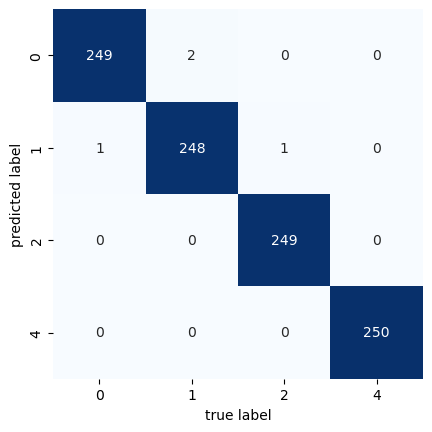

In [51]:
y_pred = predict(X_, clf1, clf2, clf3, clf4, clf5, clf6, a_min1, a_min2, a_min3, a_min4, a_min5, a_min6)

# Plot the confusion matrix.
mat = confusion_matrix(y, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, xticklabels=['0','1','2','4'], yticklabels=['0','1','2','4'], cmap="Blues")
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [52]:
# Calculate accuracy of class predictions.
accuracy_score(y, y_pred)

0.996

### Regiões de decisão resultantes da combinação dos $Q(Q-1)/2=6$ classificadores binários.

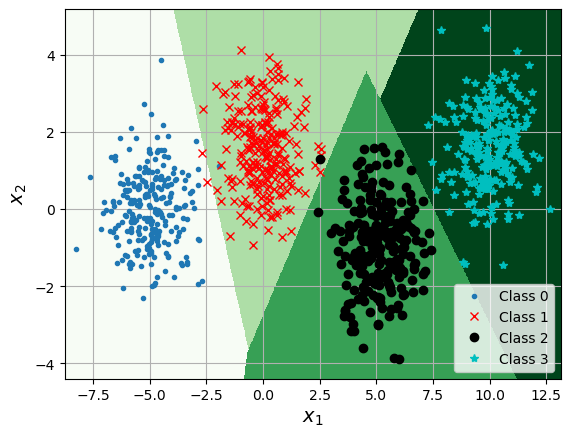

In [53]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# This attribute matrix must also follow the same shape 
# as the one created for the training.
attribute_matrix = np.c_[np.ones((len(xx.ravel()), 1)), xx.ravel(), yy.ravel()]

Z = predict(attribute_matrix, clf1, clf2, clf3, clf4, clf5, clf6, a_min1, a_min2, a_min3, a_min4, a_min5, a_min6)

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Greens, shading='auto')

# Plot also the training points.
plt.plot(X[idx0,0], X[idx0,1], '.', label='Class 0')
plt.plot(X[idx1,0], X[idx1,1], 'rx', label='Class 1')
plt.plot(X[idx2,0], X[idx2,1], 'ko', label='Class 2')
plt.plot(X[idx3,0], X[idx3,1], 'c*', label='Class 3')
plt.xlabel('$x_1$', fontsize=14)
plt.ylabel('$x_2$', fontsize=14)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.grid()
plt.legend(loc='lower right')
plt.show()